In [1]:
from pmotifs.config import config

In [2]:
from pathlib import Path



ANALYSIS_CANDIDATES = {
    "yeast": {
        "edgelist": config.DATASET_DIRECTORY /  "yeastInter_st.txt",
        "outpath": config.EXPERIMENT_OUT / "pmotif_detection",
    },
}

In [3]:
CANDIDATE = "yeast"

GRAPH_EDGELIST = ANALYSIS_CANDIDATES[CANDIDATE]["edgelist"]
OUT = ANALYSIS_CANDIDATES[CANDIDATE]["outpath"]
GRAPHLET_SIZE = 3

In [4]:
# Retrieve Graphlets and their metrics
from pmotifs.PMotifGraph import PMotifGraph


g = PMotifGraph(GRAPH_EDGELIST, OUT)

In [5]:
g_p = g.load_graphlet_pos_zip(GRAPHLET_SIZE)

Load Graphlet Positions: 100%|████████| 13150/13150 [00:00<00:00, 166926.74it/s]


In [6]:
g_pm = g.load_positional_data(GRAPHLET_SIZE)

Loading Graphlet Metrics: 100%|███████| 13150/13150 [00:00<00:00, 157742.83it/s]


In [7]:
graphlet_lookup = dict(zip(g_p, g_pm.graphlet_metrics))

In [8]:
import pandas as pd

df = pd.DataFrame([
    {**k.__dict__, **v.__dict__}
    for k,v in graphlet_lookup.items()
])
print(df.shape)
df.head()

(13150, 5)


,graphlet_class,nodes,degree,anchor_node_distances,graph_module_participation
0,011 100 100,"[1, 199, 352]",10,"[4, 3, 2, 1, 2, 5, 2, 3, 4, 4, 3, 2, 3, 2, 3, ...",[0]
1,011 100 100,"[1, 199, 203]",8,"[4, 3, 3, 1, 2, 4, 1, 4, 4, 3, 4, 3, 3, 3, 3, ...","[0, 10]"
2,011 100 100,"[1, 199, 200]",9,"[3, 3, 3, 1, 1, 4, 1, 3, 4, 3, 3, 3, 3, 3, 3, ...","[0, 10]"
3,011 100 100,"[1, 199, 198]",11,"[3, 2, 2, 1, 2, 4, 1, 3, 3, 3, 3, 2, 3, 2, 3, ...",[0]
4,011 100 100,"[1, 199, 197]",17,"[3, 2, 2, 0, 2, 4, 1, 3, 3, 3, 3, 2, 2, 2, 2, ...",[0]


In [9]:
graphlet_classes = set(df["graphlet_class"])
graphlet_classes

{'011 100 100', '011 101 110'}

# Node Choice

In [10]:
relevant_node = "205"

nx_g = g.load_graph()
assert relevant_node in nx_g.nodes, "No such node!"

# Analysis

In [11]:
relevant_motifs = df[df["nodes"].apply(lambda nodes: relevant_node in nodes)]
relevant_motifs.head()
relevant_motifs.shape

(33, 5)

([<matplotlib.patches.Wedge at 0x7fced208c0a0>,
 [Text(-1.055442297353649, 0.30990572269135613, '3-Dash'),
  Text(1.0554423263691122, -0.30990562387371495, 'Triangle')],
 [Text(-0.5756957985565357, 0.16903948510437605, '30'),
  Text(0.5756958143831521, -0.1690394312038445, '3')])

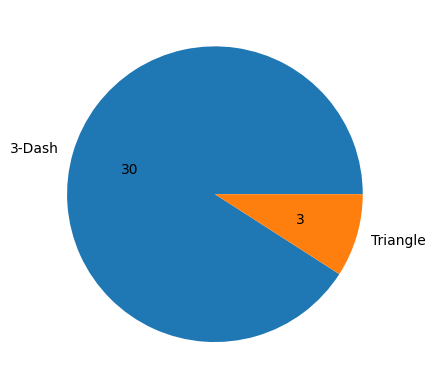

In [12]:
import matplotlib.pyplot as plt

from pmotifs.graphlet_representation import graphlet_class_to_name

grouped_by_class_df = relevant_motifs.groupby("graphlet_class").agg("count")
total = sum(grouped_by_class_df["nodes"])

plt.pie(
    list(grouped_by_class_df["nodes"]),
    labels=list(map(graphlet_class_to_name, grouped_by_class_df.index)),
    autopct=lambda p: int(total * p / 100),
)

In [13]:
METRIC_NAME = "degree"

In [14]:
"""Tukey Method"""
from scipy.stats import iqr
from scipy.stats.mstats import mquantiles

metrics = df[METRIC_NAME].astype(float)

q1, q2, q3 = mquantiles(metrics)
inner_quantile_range = iqr(metrics)

lower_outlier_cut = q1 - 1.5 * inner_quantile_range
upper_outlier_cut = q3 + 1.5 * inner_quantile_range

print(f"Outliers: x < {lower_outlier_cut}, {upper_outlier_cut} > x")

lower_outlier = 0
upper_outlier = 0
for relevant_motif_metric in relevant_motifs[METRIC_NAME]:
    
    if relevant_motif_metric < lower_outlier_cut:
        lower_outlier += 1
    if relevant_motif_metric > upper_outlier_cut:
        upper_outlier += 1

print(f"{lower_outlier}/{len(relevant_motifs)} motifs are lower outliers")
print(f"{upper_outlier}/{len(relevant_motifs)} motifs are upper outliers")

Outliers: x < -17.0, 95.0 > x
0/33 motifs are lower outliers
0/33 motifs are upper outliers


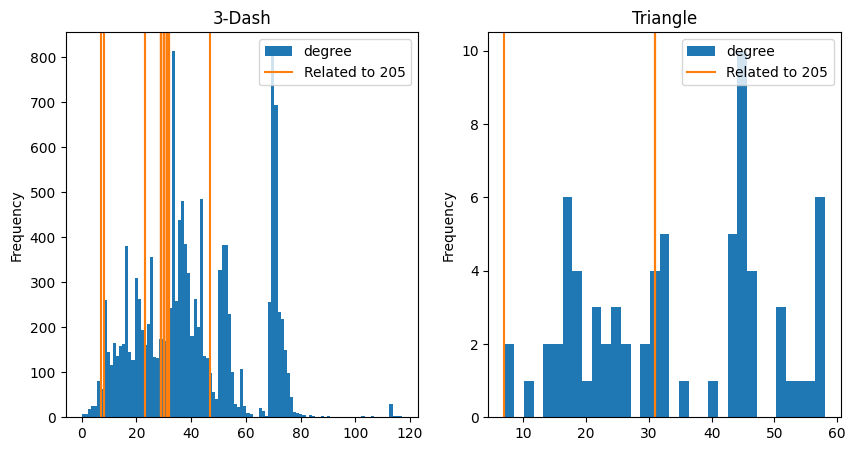

In [15]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from pmotifs.graphlet_representation import graphlet_class_to_name


fig, axes = plt.subplots(1, len(grouped_by_class_df.index), figsize=(10,5))


for i, graphlet_class in enumerate(grouped_by_class_df.index):
    ax = axes[i]
    
    graphlet_class_df = df[df["graphlet_class"] == graphlet_class]
    
    bars = graphlet_class_df.plot.hist(bins=len(set(graphlet_class_df[METRIC_NAME])), ax=ax)

    relevant_motifs_for_class = relevant_motifs[
        relevant_motifs["graphlet_class"] == graphlet_class
    ]

    for relevant_motif_metric in relevant_motifs_for_class[METRIC_NAME]:
        ax.axvline(
            relevant_motif_metric,
            color="tab:orange",
        )
    ax.axvline(
        relevant_motif_metric,
        color="tab:orange",
        label=f"Related to {relevant_node}"
    )

    ax.legend()
    ax.set_title(graphlet_class_to_name(graphlet_class))

In [16]:
import networkx as nx

def prepare_kamada_kawai_layout_with_multiple_components(nx_g):
    pos_df = pd.DataFrame(index=nx_g.nodes(), columns=nx_g.nodes())
    max_dist = -1
    for row, data in nx.shortest_path_length(nx_g):
        for col, dist in data.items():
            pos_df.loc[row,col] = dist
            max_dist = max(max_dist, dist)

    pos_df = pos_df.fillna(max_dist / 2 + 2)

    return nx.kamada_kawai_layout(nx_g, dist=pos_df.to_dict())

In [17]:
"""Prepare Graph Plotting"""
import networkx as nx

nx_g = g.load_graph()
pos = prepare_kamada_kawai_layout_with_multiple_components(nx_g)

In [18]:
def highlight_motif(nx_g, motif, ax, pos):
    subgraph = nx.induced_subgraph(nx_g, motif)

    nx.draw_networkx_nodes(
        nx_g,
        nodelist=subgraph.nodes,
        node_color='r',
        pos=pos,
        ax=ax,
        node_size=20,
    )
    nx.draw_networkx_labels(
        nx_g,
        labels={node: node for node in subgraph.nodes},
        pos=pos,
        ax=ax,
        font_size=6,
        font_color='b',
    )
    nx.draw_networkx_edges(
        nx_g,
        pos=pos,
        edgelist=subgraph.edges,
        ax=ax,
        edge_color="r",
    )

In [19]:
def plot_graph_with_motif_highlight(nx_g, motifs, pos, ax, title=""):
    nx.draw(nx_g, pos=pos, ax=ax, node_size=20)

    for m in motifs:
        highlight_motif(nx_g, m, ax, pos)

    ax.set_title(title)

In [20]:
def get_zommed_graph(nx_g, nodes, node_range=3):
    relevant_nodes = []
    for n in nodes:
        neighbors = nx.descendants_at_distance(nx_g, n, node_range)
        relevant_nodes.extend(neighbors)
        relevant_nodes.append(n)
    
    subgraph = nx.induced_subgraph(nx_g, relevant_nodes)
    
    return subgraph
    

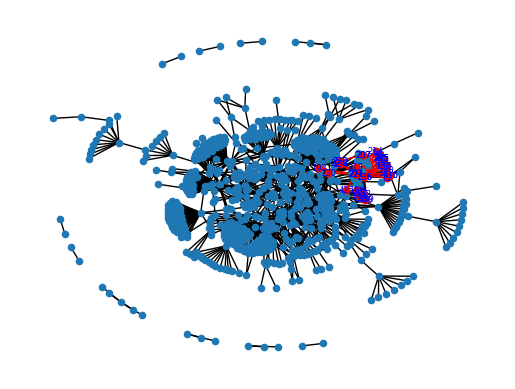

In [23]:
fig, ax = plt.subplots(1,1)
plot_graph_with_motif_highlight(nx_g, [r_m for r_m in relevant_motifs["nodes"]], pos, ax)

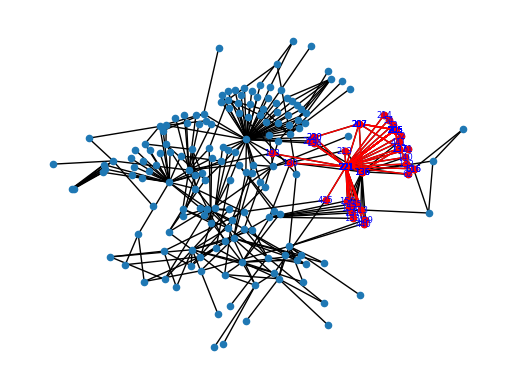

In [29]:
fig, ax = plt.subplots(1,1)
plot_graph_with_motif_highlight(
    get_zommed_graph(nx_g, {n for r_m in relevant_motifs["nodes"] for n in r_m}),
    [r_m for r_m in relevant_motifs["nodes"]],
    pos,
    ax,
)